In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir

Welcome to JupyROOT 6.22/06


In [2]:
class particle:
    def __init__(self, pid, fourvector, Q2, Nu):
        #In the lab frame, but with the photon is aligned with z-direction, the photon has 4-momentum q= (0,0,sqrt(Nu2+Q2),Nu) (note q2 = -Q2)        
        self.virtual_photon = ROOT.TLorentzVector()
        self.virtual_photon.SetPxPyPzE(0,0,np.sqrt(Nu*Nu+Q2),Nu)
        self.virtual_photon_CM = self.virtual_photon
        self.proton = ROOT.TLorentzVector()
        self.proton.SetPxPyPzE(0,0,0, 0.938)
        self.proton_CM = self.proton
        
        self.W = (self.virtual_photon + self.proton).M()
        self.MissingMass = (self.virtual_photon + self.proton - fourvector).M()
        
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.0,5.0)####INCONSISTENT
        part1 = self.virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = self.virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        self.virtual_photon_CM.Boost(0.0,0.0,-self.bcm)
        self.proton_CM.Boost(0.0,0.0,-self.bcm)
        
        self.LorentzVector = fourvector #hadron four-vector
        self.PhiLab = self.LorentzVector.Phi()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(self.virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(self.virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.mass = self.LorentzVector.M() 
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star)
        self.Pstar = np.sqrt(self.Pl_star*self.Pl_star + self.Pt*self.Pt)
        self.eta = np.arctanh(self.Pl_star/self.Pstar)
        #self.eta =  0.5*np.log( (self.Pstar+self.Pl_star)/(self.Pstar-self.Pl_star)) 
        
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.Xb = Q2/(2*0.938*Nu)

        #'phi =%2.2f'%self.PhiLab,
    def print_properties(self):
        #print ('Hello, let me introduce myself, i am particle pid = ' , self.pid)
        #print ('PID', self.pid, ' zh = %2.2f'%self.Zh,  'E = %2.2f'%self.E, 'phi =%2.2f'%self.PhiLab,'theta=%2.2f'%self.LorentzVector.Theta(),'pt %2.2f'%self.Pt)
        print ('PID', self.pid, ' pT = %2.2f'%self.Pt,  'Pl= %2.2f'%self.Pl_star, 'Xf=%2.2f'%self.Xf, 'Zh=%2.2f'%self.Zh, 'phi =%2.2f'%self.PhiLab)

        
        #print ('%2.3f,'%self.LorentzVector.Px(),'%2.3f,'%self.LorentzVector.Py(),'%2.3f,'%self.LorentzVector.Pz(), '%2.23f,'%self.LorentzVector.E())


In [3]:
class mytupla:
    def __init__(self):
        
        hadron_variables = ['pid','xf','z','y','ycm','pt','Q2','Xb','Nu','W','MissingMass','phi_pq','theta_pq',
                             'TargType','phi_lab','theta_lab','pos_x','pos_y','pos_z']
        
        self.tupla_hadron = {}
        for var in hadron_variables:
            self.tupla_hadron[var] = []    
            
            
        electron_variables = ['Q2','Xb','Nu','W','costheta']
        self.tupla_electron = {}
        for var in electron_variables:
            self.tupla_electron[var] = [] 

In [4]:

def getDataframes(filename, Target=1,maxevents=1e9,beamenergy=5.0):
    dphi = np.array([])
    ParticlesFromPrevious = []
    try:
        myfile = TFile.Open('%s'%filename,'READ')
    except:
        print("could not open file")

        
    myfile.Print()
    mytree = myfile.Get('RootTuple')
    
    print (filename, ' has ', mytree.GetEntries(), ' entries')
    print ('The max number of events to be analyzes is ', maxevents)
    df = mytupla()    
    
    start = time.time()
    for ievt  in range(mytree.GetEntries()):
        if(ievt%1e5==0):
            print ('Event # ', ievt)
            end = time.time()
            print ('Processed in',  end-start, 'seconds')
            start = time.time()
        mytree.GetEntry(ievt)   
        if mytree.Q2<1.0: continue
        if ievt>maxevents: break
        Nu = mytree.nu
        Q2 = mytree.Q2
        phi_e = mytree.phiL 
        E    = beamenergy
        Eprime = E-Nu
        
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,E,E)
        
        #scattered electron
        scattered_e = ROOT.TLorentzVector()
        cos_thetae = 1-Q2/(2*E*Eprime)
        sin_thetae = np.sqrt(1-cos_thetae*cos_thetae)
        scattered_e.SetPxPyPzE(Eprime*sin_thetae*np.cos(phi_e),
                               Eprime*sin_thetae*np.sin(phi_e),
                               Eprime*cos_thetae,
                               Eprime)
        virtual_photon  = incoming_e - scattered_e
        virtual_photon_unitvector = virtual_photon.Vect().Unit()

        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)

        df.tupla_electron['Q2'].append(Q2)
        df.tupla_electron['Xb'].append(0)
        df.tupla_electron['Nu'].append(Nu)
        df.tupla_electron['W'].append(0)
        df.tupla_electron['costheta'].append(cos_thetae)
        
        for i in range(len(mytree.Px)):
            if abs(mytree.barcode[i]) !=211: continue
            i_lv = ROOT.TLorentzVector()    
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.E[i]) #with respect to photon direction
            i_part = particle(mytree.barcode[i], i_lv, Q2, Nu)
            df.tupla_hadron['TargType'].append(999)
            df.tupla_hadron['pid'].append(i_part.pid)
            df.tupla_hadron['xf'].append(i_part.Xf)
            df.tupla_hadron['z'].append(i_part.Zh)
            df.tupla_hadron['y'].append(i_part.y_star)
            df.tupla_hadron['ycm'].append(i_part.ycm)
            df.tupla_hadron['pt'].append(i_part.LorentzVector.Pt())
            df.tupla_hadron['phi_pq'].append(i_part.PhiPQ)
            df.tupla_hadron['theta_pq'].append(i_part.ThetaPQ)
            df.tupla_hadron['Q2'].append(Q2)
            df.tupla_hadron['Xb'].append(i_part.Xb)
            df.tupla_hadron['Nu'].append(Nu)
            df.tupla_hadron['W'].append(i_part.W)
            df.tupla_hadron['MissingMass'].append(i_part.MissingMass)
            df.tupla_hadron['phi_lab'].append(i_part.LorentzVector.Phi())
            df.tupla_hadron['theta_lab'].append(i_part.LorentzVector.Theta())
            df.tupla_hadron['pos_x'].append(mytree.x[i])
            df.tupla_hadron['pos_y'].append(mytree.y[i])
            df.tupla_hadron['pos_z'].append(mytree.z[i])
             
        
        
    end = time.time()
    print ('Processed in',  end-start, 'seconds')
    df_hadron = pd.DataFrame(df.tupla_hadron)
    df_electron = pd.DataFrame(df.tupla_electron)
    return df_electron,df_hadron

In [5]:
df = {}

## Configuration for CLAS6

In [6]:
nevents = 5e6
beamenergy = 5.0
df = {}

In [20]:
df['Pb_electron'], df['Pb_hadron'] = getDataframes('/home/miguel/GiBUU/GiBUU_Pb.root',maxevents=1e7)

/home/miguel/GiBUU/GiBUU_Pb.root  has  8315826  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 3.790855407714844e-05 seconds
Event #  100000
Processed in 13.568294286727905 seconds
Event #  200000
Processed in 13.418920993804932 seconds
Event #  300000
Processed in 13.593024969100952 seconds
Event #  400000
Processed in 13.35973072052002 seconds
Event #  500000
Processed in 13.373798608779907 seconds
Event #  600000
Processed in 13.47314190864563 seconds
Event #  700000
Processed in 13.554674863815308 seconds
Event #  800000
Processed in 13.426145553588867 seconds
Event #  900000
Processed in 13.491627931594849 seconds
Event #  1000000
Processed in 13.613028526306152 seconds
Event #  1100000
Processed in 13.805252075195312 seconds
Event #  1200000
Processed in 13.7986421585083 seconds
Event #  1300000
Processed in 13.632934331893921 seconds
Event #  1400000
Processed in 13.537825107574463 seconds
Event #  1500000
Processed in 13.845849990844727 s

In [21]:
df['Fe_electron'], df['Fe_hadron'] = getDataframes('/home/miguel/GiBUU/GiBUU_Fe.root',maxevents=1e7)

/home/miguel/GiBUU/GiBUU_Fe.root  has  5596315  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 0.00020456314086914062 seconds
Event #  100000
Processed in 13.316233396530151 seconds
Event #  200000
Processed in 13.213930130004883 seconds
Event #  300000
Processed in 13.239636659622192 seconds
Event #  400000
Processed in 13.359238147735596 seconds
Event #  500000
Processed in 13.336331605911255 seconds
Event #  600000
Processed in 13.233602285385132 seconds
Event #  700000
Processed in 13.219898700714111 seconds
Event #  800000
Processed in 13.293957471847534 seconds
Event #  900000
Processed in 13.300434350967407 seconds
Event #  1000000
Processed in 13.265069246292114 seconds
Event #  1100000
Processed in 13.239547491073608 seconds
Event #  1200000
Processed in 13.284649133682251 seconds
Event #  1300000
Processed in 13.258842706680298 seconds
Event #  1400000
Processed in 13.20943570137024 seconds
Event #  1500000
Processed in 13.2055945396423

In [22]:
df['C_electron'], df['C_hadron'] = getDataframes('/home/miguel/GiBUU/GiBUU_C.root',maxevents=1e7)

/home/miguel/GiBUU/GiBUU_C.root  has  21776066  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 3.266334533691406e-05 seconds
Event #  100000
Processed in 12.62545919418335 seconds
Event #  200000
Processed in 12.5883150100708 seconds
Event #  300000
Processed in 12.514225244522095 seconds
Event #  400000
Processed in 12.572814226150513 seconds
Event #  500000
Processed in 12.575161933898926 seconds
Event #  600000
Processed in 12.50590968132019 seconds
Event #  700000
Processed in 12.644439458847046 seconds
Event #  800000
Processed in 12.604361295700073 seconds
Event #  900000
Processed in 12.665817975997925 seconds
Event #  1000000
Processed in 12.664441585540771 seconds
Event #  1100000
Processed in 12.41574478149414 seconds
Event #  1200000
Processed in 12.336829662322998 seconds
Event #  1300000
Processed in 12.307470083236694 seconds
Event #  1400000
Processed in 12.328486919403076 seconds
Event #  1500000
Processed in 12.755948781967163 se

In [23]:
df['D_electron'], df['D_hadron'] = getDataframes('/home/miguel/GiBUU/GiBUU_D.root',maxevents=1e7)

/home/miguel/GiBUU/GiBUU_D.root  has  8363332  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 3.814697265625e-05 seconds
Event #  100000
Processed in 11.755199432373047 seconds
Event #  200000
Processed in 11.700455665588379 seconds
Event #  300000
Processed in 11.779578447341919 seconds
Event #  400000
Processed in 11.724453926086426 seconds
Event #  500000
Processed in 11.77158260345459 seconds
Event #  600000
Processed in 11.676728248596191 seconds
Event #  700000
Processed in 11.75501537322998 seconds
Event #  800000
Processed in 11.768304109573364 seconds
Event #  900000
Processed in 11.785336256027222 seconds
Event #  1000000
Processed in 11.743459701538086 seconds
Event #  1100000
Processed in 11.804808616638184 seconds
Event #  1200000
Processed in 11.77608585357666 seconds
Event #  1300000
Processed in 11.739460706710815 seconds
Event #  1400000
Processed in 11.720711469650269 seconds
Event #  1500000
Processed in 11.77577257156372 secon

In [24]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

## Save dataframes to ROOT files

In [25]:
to_root(df['D_electron'],'GiBUU_SingleHadron_D.root', key='D_electron')
to_root(df['D_hadron'],'GiBUU_SingleHadron_D.root', key='D_hadron', mode='a')

In [26]:
to_root(df['C_electron'],'GiBUU_SingleHadron_C.root', key='C_electron')
to_root(df['C_hadron'],'GiBUU_SingleHadron_C.root', key='C_hadron', mode='a')

In [27]:
to_root(df['Fe_electron'],'GiBUU_SingleHadron_Fe.root', key='Fe_electron')
to_root(df['Fe_hadron'],'GiBUU_SingleHadron_Fe.root', key='Fe_hadron', mode='a')

In [28]:
to_root(df['Pb_electron'],'GiBUU_SingleHadron_Pb.root', key='Pb_electron')
to_root(df['Pb_hadron'],'GiBUU_SingleHadron_Pb.root', key='Pb_hadron', mode='a')

## Check simulated data

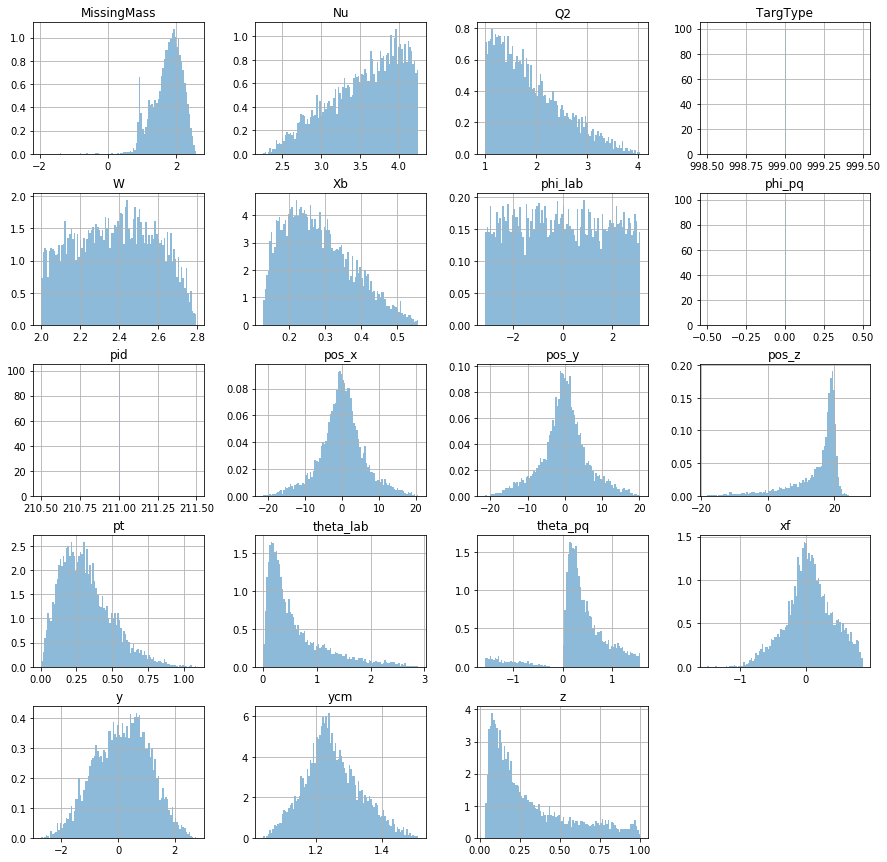

In [16]:
df['D_hadron'].query('pid==211').hist(figsize=(15, 15),density=True,alpha=0.5,bins=100)
plt.show()

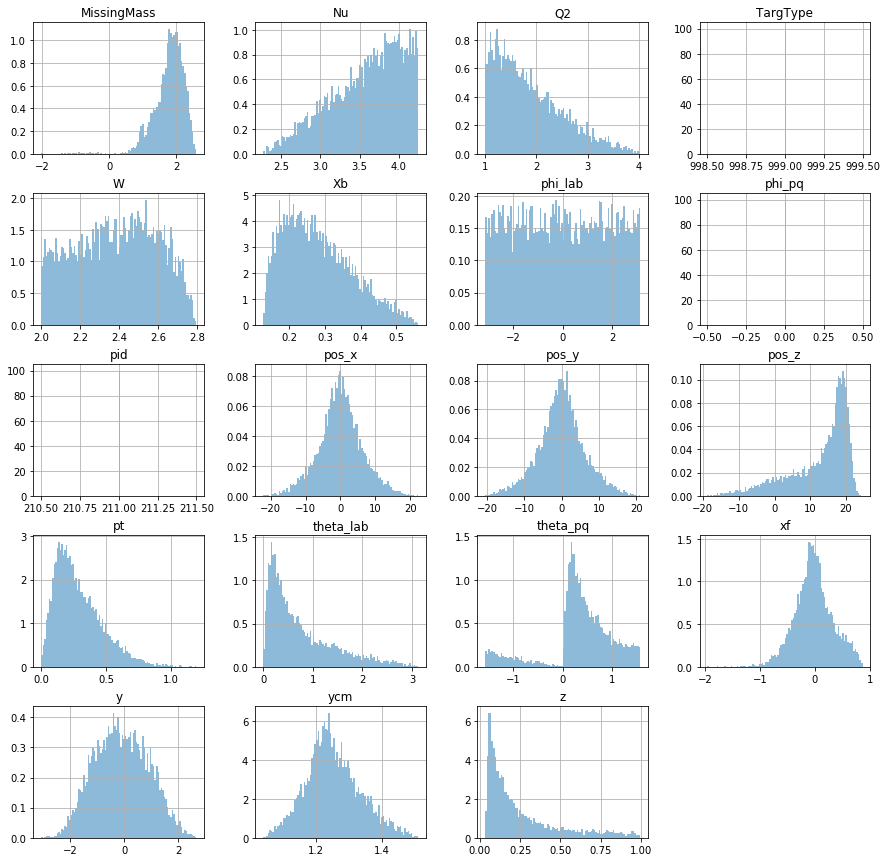

In [17]:
df['C_hadron'].query('pid==211').hist(figsize=(15, 15),density=True,alpha=0.5,bins=100)
plt.show()

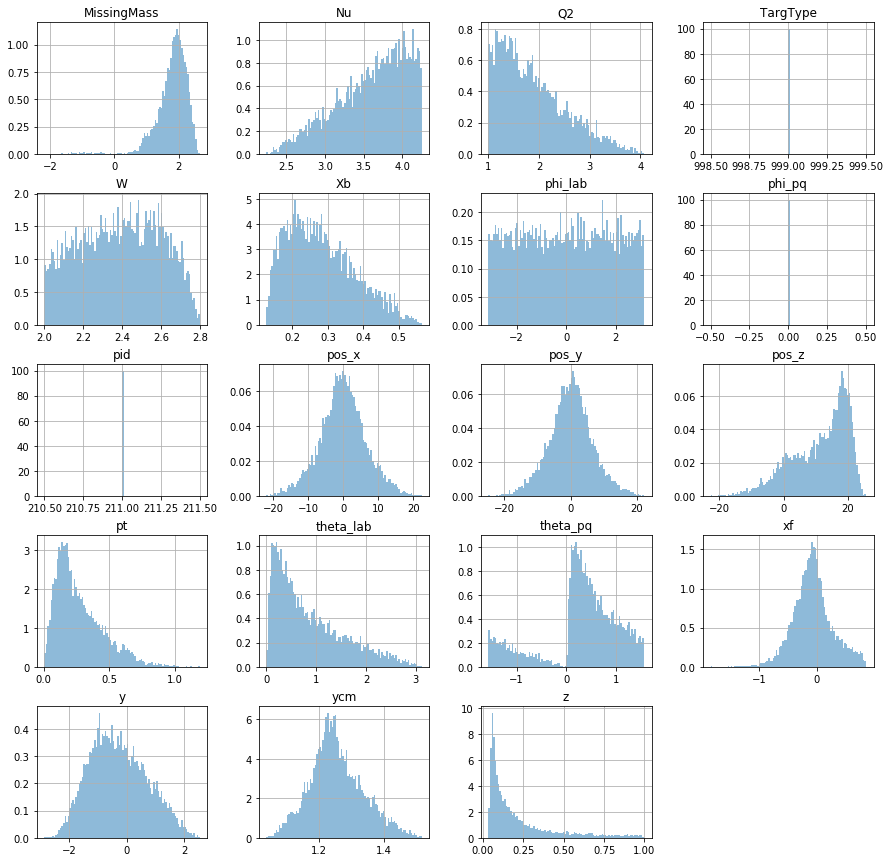

In [18]:
df['Fe_hadron'].query('pid==211').hist(figsize=(15, 15),density=True,alpha=0.5,bins=100)
plt.show()

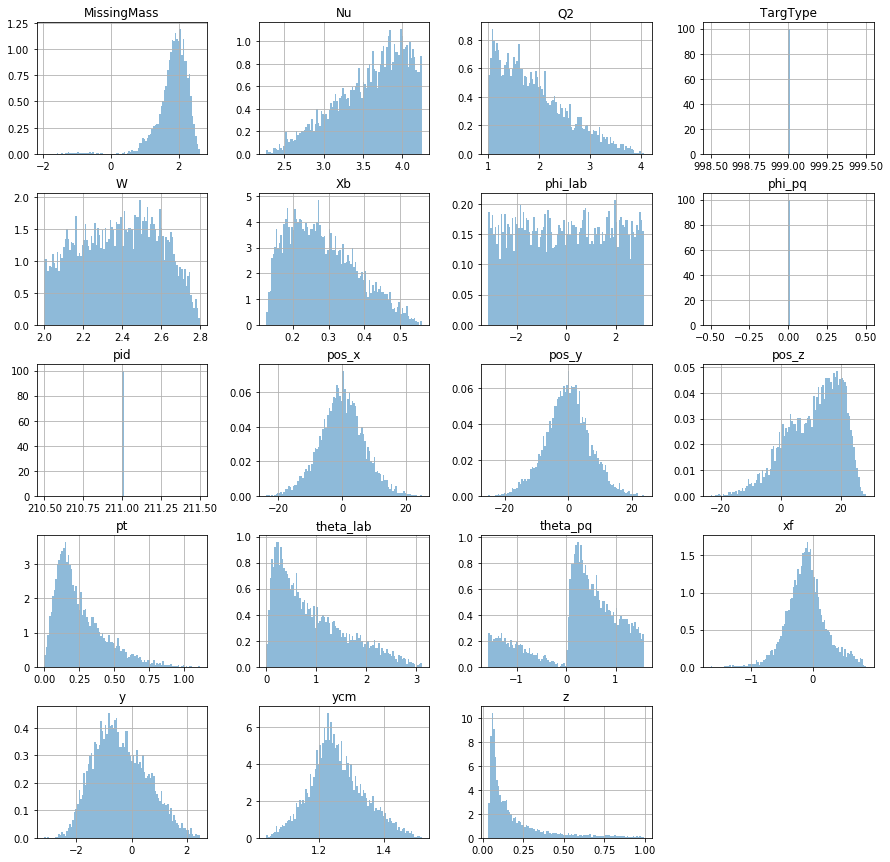

In [19]:
df['Pb_hadron'].query('pid==211').hist(figsize=(15, 15),density=True,alpha=0.5,bins=100)
plt.show()